# Bandits

A minimalist notebook to experiement with bandit environments and agents.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from scipy.stats import invgamma, gamma
from scipy.stats import t as student

## Environment
The Multi-Armed Bandit setting is as follow: 

At each step you have to chose one arm to pull and recieve a reward accordingly.

Here we consider Bernoulli rewards.

In [2]:
class MAB:
    """ 
    Multi-Armed Bandit environment with bernoulli rewards.
    """
    def __init__(self, mean_reward, seed=None):
        self._nb_arms = len(mean_reward)
        self._mean_reward = mean_reward
        self._rng = np.random.RandomState(seed)
        self._optimal_return = np.max(self._mean_reward)
    
    def step(self, action):
        """ Play an action """
        reward = self._rng.binomial(p=self._mean_reward[action], n=1, size=1)[0]
        return reward

#### Example
Set a Bernoulli Multi-Armed Bandit with reward probability of 
- 50% for arm A
- 20% for arm B
- 80% for arm C

In [3]:
env = MAB(mean_reward=[0.5, 0.2, 0.8], seed=2020)

Let's play arm B once:

In [4]:
env.step(1)

1

We get a reward of 1.

Let's now play arm C.

In [5]:
env.step(2)

0

We get no reward.

Now let's build an Agent that will play with our environment.

## Agent
Here we create a very basic agent that will pull arm, i.e.play action, at random.

In [6]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self):
        action = self._rng.randint(self._nb_arms)
        return action
        
    def update(self, action, reward):
        pass


#### Example
Let's build an Agent and ask him to choose an action

In [7]:
agent = Random(nb_arms=3, seed=2020)
agent.act()

0

Here the agent choose to play arm A.

## Run experiment
In order to make Agent and Environment interract, we can create an experiment, parametrized by the number of step we will be running.

In [8]:
def run_exp(agent, env, nb_steps):
    rewards = np.zeros(nb_steps)
    regrets = np.zeros(nb_steps)
    actions = np.zeros(nb_steps)
    
    for i in range(nb_steps):
        # Select action from agent policy.
        action = agent.act()
        
        # Play action in the environment and get reward.
        reward = env.step(action)
        
        # Update agent.
        agent.update(action, reward)
        
        # Save history.
        rewards[i] = reward
        actions[i] = action

    reward = rewards.sum()
    regrets = env._optimal_return - rewards
    regret = np.sum(regrets)
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets)
            }


#### Example
Let's run our previous agent and environment 100 times.

In [9]:
run_exp(agent, env, nb_steps=100)

{'reward': 53.0,
 'regret': 27.0,
 'rewards': array([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.]),
 'regrets': array([-0.2, -0.2,  0.8,  0.8,  0.8,  0.8, -0.2,  0.8, -0.2,  0.8, -0.2,
        -0.2, -0.2,  0.8,  0.8, -0.2,  0.8,  0.8,  0.8,  0.8,  0.8, -0.2,
         0.8, -0.2,  0.8, -0.2,  0.8,  0.8, -0.2,  0.8, -0.2, -0.2, -0.2,
        -0.2, -0.2, -0.2,  0.8,  0.8,  0.8, -0.2, -0.2, -0.2, -0.2, -0.2,
        -0.2,  0.8,  0.8, -0.2, -0.2,  0.8, -0.2, -0.2,  0.8, -0.2, -0.2,
        -0.2,  0.8,  0.8, -0.2, -0.2, -0.2, -0.2, -0.2,  0.8,  0.8,  0.8,
        -0.2, -0.2, -0.2, -0.2,  0.8,  0.8,  0.8, 

You can see that on this experiment the total reward is 53 and the regret is 27. You can also have a look at individual rewards, actions or regrets.

Due to stochasticity of both the environment and the agent, it's better to run multiple experiments.

## Multiple experiments

In order to get empirical confidence bound on those statistics we can run the experiment multiple time.

Hint: don't forget to change the seed. 

In [10]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MAB([0.5, 0.2, 0.8], seed=i)
    agent = Random(env._nb_arms, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

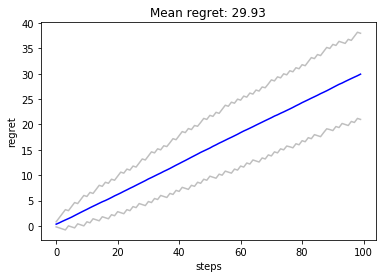

In [11]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

Here you can see the average regret over steps and the empirical 5% and 95% confidence intervall.

Note that the stochasticity is may comes from the agent and/or the environment.

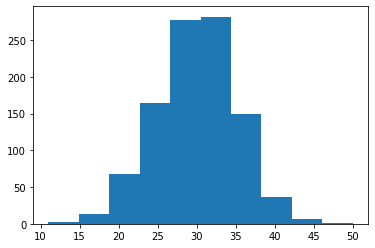

In [12]:
plt.hist(regret)
plt.show()

Here is the distribution of the total regret.

In this simple case you could compute it exactly by hand.

# Exercices:

1. Implement an epsilon-greedy agent.
2. Implement an UCB agent.
3. Implement a Thompson sampling agent.

## 1. Epsilon-greedy 

In [13]:
def random_argmax(rng, list_):
    """ similar to np.argmax but return a random element among max
        when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [14]:
class EpsilonGreedy:
    """ Epsilon greedy agent. """
    def __init__(self, nb_arms, epsilon=0, seed=None):
        self._nb_arms = nb_arms
        self._epsilon = epsilon
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(nb_arms)
        self._n = np.zeros(nb_arms)
        
    def act(self):
        if self._rng.random() < self._epsilon:
            action = self._rng.randint(self._nb_arms)
        else:
            action = random_argmax(self._rng, self._q)
        return action
        
    def update(self, action, reward):
        self._n[action] += 1
        self._q[action] += (reward - self._q[action])/self._n[action]

In [15]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MAB([0.5, 0.2, 0.8], seed=i)
    agent = EpsilonGreedy(env._nb_arms, epsilon=0.1, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

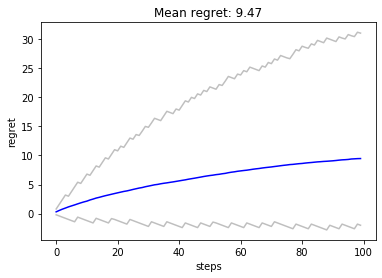

In [16]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

## 2. UCB

In [17]:
class UCB:
    """ Upper Confidence Bound agent. """

    def __init__(self, nb_arms, c=2., seed=None):
        self._nb_arms = nb_arms
        self._c = c
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(nb_arms)
        self._n = np.zeros(nb_arms)
        self._t = 0
        
    def act(self):
        if 0 in self._n:
            """ Play each action at least once. """
            action = self._rng.choice(np.where(self._n==0)[0])
        else:
            action = np.argmax(self._q + 
                               np.sqrt(self._c * np.log(self._t) / self._n))
            
        return action
        
    def update(self, action, reward):
        self._t += 1
        self._n[action] += 1
        self._q[action] += (reward - self._q[action])/self._n[action]


In [18]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MAB([0.5, 0.2, 0.8], seed=i)
    agent = UCB(env._nb_arms, 0.1, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

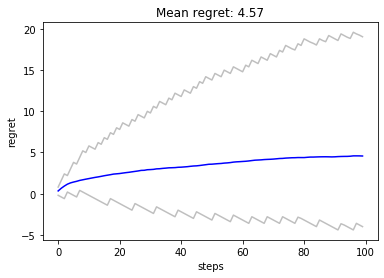

In [19]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

## 3. Thompson sampling

In [20]:
class BetaBernoulli(object):
    """ Beta Bernoulli Bayesian distribution. """
    def __init__(self, a=1, b=1, prior=np.ones(2)):
        self.a = a
        self.b = b
        self.n = copy(prior)  # number of {0,1} rewards

    def update(self, reward):
        self.n[int(reward)] += 1

    def sample(self, np_random):
        return np_random.beta(self.a + self.n[1], self.b + self.n[0])

class Thompson_sampling:
    """ Thompson sampling agent. """
    def __init__(self, nb_arms, dist=BetaBernoulli, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        self._posterior = [dist() for i in range(self._nb_arms)]
        
    def act(self):
        sample = np.array([self._posterior[i].sample(self._rng)
                           for i in range(self._nb_arms)])
        action = np.argmax(sample)
        return action
        
    def update(self, action, reward):
        self._posterior[action].update(reward)

In [21]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MAB([0.5, 0.2, 0.8], seed=i)
    agent = Thompson_sampling(env._nb_arms, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

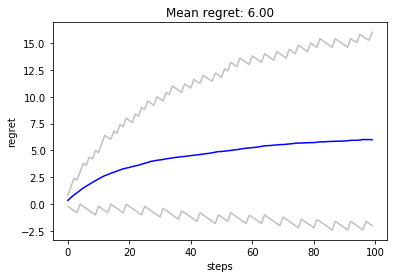

In [22]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

# Homework

1. Implement an environment for Gaussian rewards and adapt agents accordingly.
2. How agents perform under deterministic rewards ?

## Multi Armed Bandit with Gaussian rewards

In [23]:
class MABG:
    """ 
    Multi-Armed Bandit environment with gaussian rewards.
    """
    def __init__(self, mean_reward, std_reward, seed=None):
        self._nb_arms = len(mean_reward)
        self._mean_reward = mean_reward
        self._std_reward = std_reward
        self._rng = np.random.RandomState(seed)
        self._optimal_return = np.max(self._mean_reward)
    
    def step(self, action):
        """ Play an action """
        reward = self._rng.normal(loc=self._mean_reward[action],
                                    scale=self._std_reward[action], 
                                    size=1)[0]
        return reward

### Random

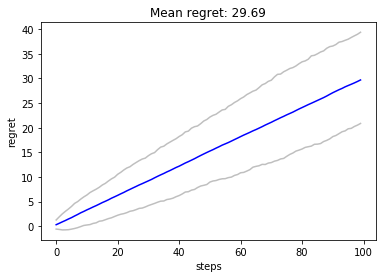

In [24]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MABG(mean_reward = [0.5, 0.2, 0.8], 
               std_reward = [0.5, 0.5, 0.5],
               seed=i)
    agent = Random(env._nb_arms, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Epsilon-greedy 

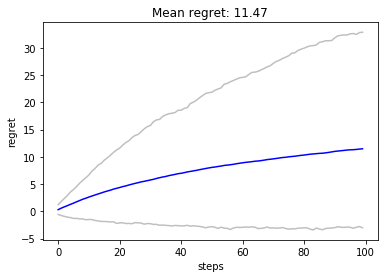

In [25]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MABG(mean_reward = [.5, .2, .8], 
               std_reward = [.5, .5, .5],
               seed=i)
    agent = EpsilonGreedy(env._nb_arms, epsilon=.1, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### UCB

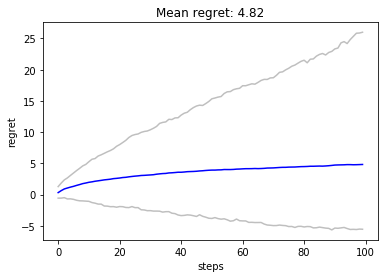

In [26]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MABG(mean_reward = [.5, .2, .8], 
               std_reward = [.5, .5, .5],
               seed=i)
    agent = UCB(env._nb_arms, c=.1, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Thompson sampling
Reference: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf

In [27]:
class NormalGamma(object):
    """ NG(m, λ|µ = ·, κ = 0, α = −1/2, β = 0) """
    def __init__(self):
        self.mean = 0
        self.ss = 0
        self.n = 0

    def update(self, reward):
        self.n += 1
        # update mean and sum of square
        old_mean = self.mean
        self.mean +=  (reward - self.mean)/self.n
        self.ss += (reward - old_mean) * (reward - self.mean) # Welford's algorithm

    def sample(self, np_random):
        if self.n <= 2:
            return np.Inf
        else:
            return student.rvs(df=self.n-1, loc=self.mean, 
                               scale=self.ss/(self.n*self.n-1),
                               random_state=np_random)

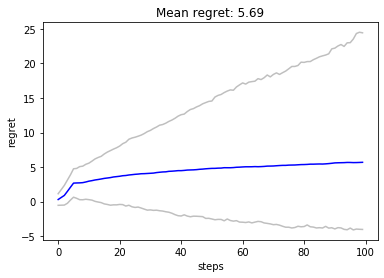

In [28]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = MABG(mean_reward = [.5, .2, .8], 
               std_reward = [.5, .5, .5],
               seed=i)
    agent = Thompson_sampling(env._nb_arms, dist=NormalGamma, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()